<a href="https://colab.research.google.com/github/asante69/Data-Analyst/blob/main/Sentiment_Analysis_with_Bag_of_Words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Importing Libraries & Loading the Data**
First things first: we import necessary libraries and load the data from GitHub.
We’re using pandas to load a CSV file directly from a GitHub repository that contains thousands of IMDb reviews. This dataset has two columns: one for the review text and one for the sentiment (labeled "positive" or "negative").

In [ ]:
import numpy as np
import pandas as pd
import re
# Set a fixed seed to ensure our results are reproducible.
np.random.seed(42)

##**Load the IMDb movie reviews dataset from GitHub**
**Note: This dataset contains text reviews and sentiment label**

In [ ]:
url = (
    "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/refs/heads/master/IMDB-Dataset.csv"
)
df = pd.read_csv(url)

# Check the shape of the data (rows, columns) and preview the first few records.
print("Data shape:", df.shape)
print(df.head())

Data shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


#**Preprocessing the Text**
Before we train a model, our text needs some cleaning. This step removes unwanted HTML tags, punctuation, and normalizes everything to lowercase. We also extract emoticons because they can be full of sentiment (think of :-) versus :().

In [ ]:
def preprocessor(text):
    """
    Clean the input text:
    - Remove HTML markup.
    - Extract emoticons and preserve them.
    - Remove non-word characters (like punctuation) and convert to lowercase.
    - Append cleaned emoticons (without the hyphen) back to the text.
    """
    # Remove HTML tags using regex
    text = re.sub(r"<[^>]*>", "", text)

    # Find emoticons (patterns like :), :-), :D, etc.)
    emoticons = re.findall(r"(?::|;|=)(?:-)?(?:\)|\(|D|P)", text)

    # Remove non-word characters, change text to lowercase, and append emoticons at the end.
    text = re.sub(r"[\W]+", " ", text.lower()) + " " + " ".join(emoticons).replace("-", "")
    return text

# Apply the preprocessor to our reviews
df["review_clean"] = df["review"].apply(preprocessor)

# Print a sample cleaned review (displaying the last 100 characters for brevity)
print("\nSample cleaned review:", df.loc[0, "review_clean"][-100:])


Sample cleaned review: comfortable with what is uncomfortable viewing thats if you can get in touch with your darker side  


##**Tokenizing & Building the Bag-of-Words Model**
Tokenization is simply breaking text into individual words (tokens). The bag-of-words (BoW) approach will create a vocabulary of unique words and count the number of times each appears in a review. Here, we use scikit-learn’s CountVectorizer to do the heavy lifting.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Instantiate the CountVectorizer.
# This will first split our text into tokens and then count occurrences.
vectorizer = CountVectorizer()

In [ ]:
# Fit the vectorizer on our cleaned review texts and transform them into numerical feature vectors.
X = vectorizer.fit_transform(df["review_clean"])

In [ ]:
# Let’s inspect a small portion of the resulting vocabulary.
print("\nSample vocabulary mapping (word -> index):")
sample_vocab = dict(list(vectorizer.vocabulary_.items())[:10])
print(sample_vocab)


Sample vocabulary mapping (word -> index):
{'one': 65523, 'of': 65112, 'the': 91976, 'other': 66197, 'reviewers': 77049, 'has': 41639, 'mentioned': 58782, 'that': 91940, 'after': 3161, 'watching': 100325}


In [ ]:
# Also print the bag-of-words array for the first 3 reviews.
print("\nBag-of-words representation for the first 3 reviews:")
print(X[:3].toarray())


Bag-of-words representation for the first 3 reviews:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


##**Splitting Data & Training a Logistic Regression Model**
Next, I transform the sentiment labels into a binary format (e.g., positive = 1, negative = 0), split our data into training and test sets, and then train a logistic regression classifier. Logistic regression is a popular choice due to its simplicity and interpretability—its coefficients tell us which words influence predictions...

In [ ]:
# prompt: write logistic regression model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Convert sentiment labels to numerical values
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, df["sentiment"], test_size=0.2, random_state=42
)

# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000)  # Increased max_iter
log_reg.fit(X_train, y_train)

# Evaluate the model (optional, but recommended)
from sklearn.metrics import accuracy_score

y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8882


Accuracy: 0.8882


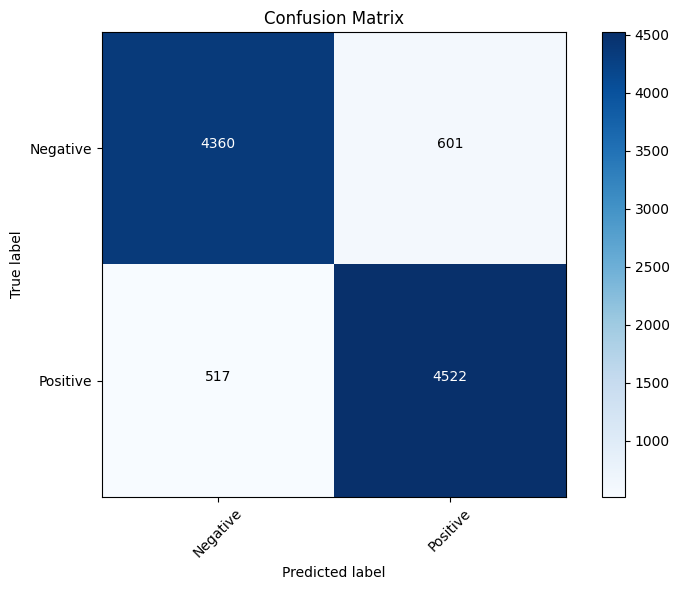

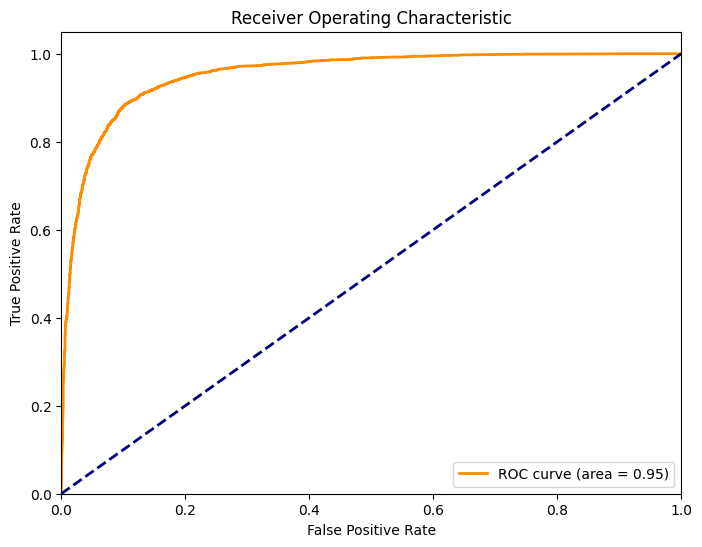

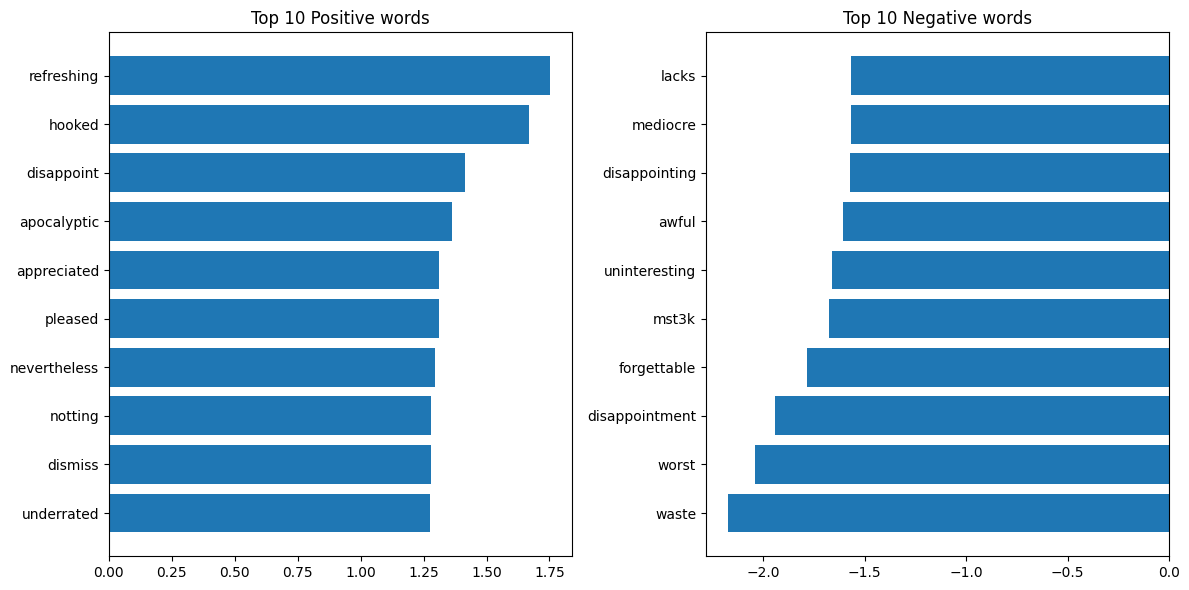

In [ ]:
# prompt: write code for graphs for the model

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# ... (Your existing code) ...

# Evaluate the model and generate metrics
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45)
plt.yticks(tick_marks, ['Negative', 'Positive'])

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# ROC Curve
y_prob = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Feature Importance (Coefficients) - Top 10 most important words
feature_names = vectorizer.get_feature_names_out()
coefficients = log_reg.coef_[0]
top_positive_indices = np.argsort(coefficients)[-10:]
top_negative_indices = np.argsort(coefficients)[:10]


plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.barh(feature_names[top_positive_indices], coefficients[top_positive_indices])
plt.title("Top 10 Positive words")

plt.subplot(1,2,2)
plt.barh(feature_names[top_negative_indices], coefficients[top_negative_indices])
plt.title("Top 10 Negative words")
plt.tight_layout()
plt.show()
